In [1]:
import math

import torch
from pyro.distributions import constraints
from pyroapi import pyro

import pyro.distributions as dist
from tqdm import trange

import pandas as pd
import matplotlib as plt

In [2]:
pyro.clear_param_store()

In [3]:
raw_data = torch.concat((torch.tensor([True, True]).repeat(80, 1), torch.tensor([True, False]).repeat(20, 1),
                         torch.tensor([False, True]).repeat(220, 1), torch.tensor([False, False]).repeat(80, 1)))
raw_data, raw_data.size()

(tensor([[ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],
         [ True,  True],


In [4]:
def model_paying_athletes(data):
    p = pyro.sample("latent_paying", dist.Beta(concentration0=.1, concentration1=.3))
    obs = data[:, 1].clone().detach().float()
    with pyro.plate("N", len(obs)):
        return pyro.sample("obs", dist.Bernoulli(p), obs=obs)

In [5]:
def guide_paying_athletes(data):
    alpha = pyro.param("alpha", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.param("beta", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("latent_paying", dist.Beta(concentration0=alpha, concentration1=beta))

In [6]:
optim = pyro.optim.Adam({"lr": 0.0125})
loss = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model_paying_athletes, guide_paying_athletes, optim, loss)

In [7]:
losses = []
params = []
indicators = []

for _ in trange(25_000):
    l = svi.step(raw_data)
    alpha = pyro.param("alpha")
    beta = pyro.param("beta")
    inferred_mean = alpha / (alpha + beta)
    factor = beta / (alpha * (1.0 + alpha + beta))
    inferred_std = inferred_mean * math.sqrt(factor)
    losses.append({"loss": l})
    params.append({"alpha": alpha.item(), "beta": beta.item()})
    indicators.append({"inferred mean": inferred_mean.item(), "inferred_std": inferred_std.item()})

100%|██████████| 25000/25000 [01:31<00:00, 273.21it/s]


In [8]:
alpha = pyro.param("alpha")
beta = pyro.param("beta")
inferred_mean = alpha / (alpha + beta)
factor = beta / (alpha * (1.0 + alpha + beta))
inferred_std = inferred_mean * math.sqrt(factor)
alpha, beta, inferred_mean, inferred_std

(tensor(97.5413, grad_fn=<AddBackward0>),
 tensor(290.5682, grad_fn=<AddBackward0>),
 tensor(0.2513, grad_fn=<DivBackward0>),
 tensor(0.0220, grad_fn=<MulBackward0>))

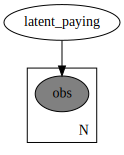

In [9]:
pyro.render_model(model_paying_athletes, model_args=(raw_data,))

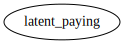

In [10]:
pyro.render_model(guide_paying_athletes, model_args=(raw_data,))

<AxesSubplot:>

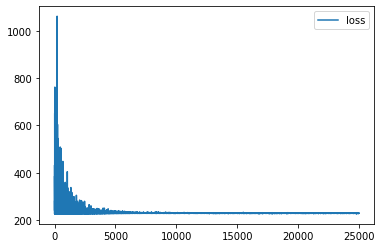

In [11]:
df = pd.DataFrame(losses)

df.plot()

<AxesSubplot:>

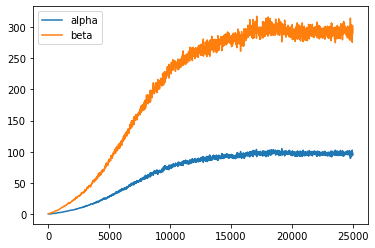

In [12]:
df = pd.DataFrame(params)

df.plot()

<AxesSubplot:>

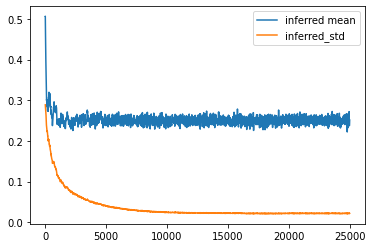

In [13]:
df = pd.DataFrame(indicators)

df.plot()

In [14]:
model_paying_athletes(raw_data)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [15]:
guide_paying_athletes(raw_data)

tensor(0.7273, grad_fn=<SelectBackward0>)

In [33]:
def model(athlete=None, paying=None, prior_a_alpha=1., prior_a_beta=1., prior_p_alpha=1., prior_p_beta=1.):
    with pyro.plate("A"):
        latent_a = pyro.sample("latent_athlete",
                               dist.Beta(concentration0=torch.as_tensor(prior_a_alpha, dtype=torch.float), concentration1=torch.as_tensor(prior_a_beta, dtype=torch.float)))
        a = pyro.sample("athlete", dist.Bernoulli(latent_a),
                        obs=athlete if athlete is None else torch.as_tensor(athlete, dtype=torch.float))
    with pyro.plate("P"):
        latent_p = pyro.sample("latent_paying",
                               dist.Beta(concentration0=torch.as_tensor(prior_p_alpha, dtype=torch.float), concentration1=torch.as_tensor(prior_p_beta, dtype=torch.float)))
        p = pyro.sample("paying", dist.Bernoulli(latent_p), obs=paying if paying is None else torch.as_tensor(paying, dtype=torch.float))
    return a, p

In [17]:
def guide(athlete=None, paying=None, prior_a_alpha=1., prior_a_beta=1., prior_p_alpha=1., prior_p_beta=1.):
    with pyro.plate("A"):
        a_alpha = pyro.param("a_alpha", torch.as_tensor(prior_a_alpha, dtype=torch.float), constraint=constraints.positive)
        a_beta = pyro.param("a_beta", torch.as_tensor(prior_a_beta, dtype=torch.float), constraint=constraints.positive)
        latent_a = pyro.sample("latent_athlete", dist.Beta(concentration0=a_alpha, concentration1=a_beta))
        if athlete is None:
            pyro.sample("athlete", pyro.Bernoulli(latent_a))
    with pyro.plate("P"):
        p_alpha = pyro.param("p_alpha", torch.tensor(1.), constraint=constraints.positive)
        p_beta = pyro.param("p_beta", torch.tensor(1.), constraint=constraints.positive)
        pyro.sample("latent_paying", dist.Beta(concentration0=p_alpha, concentration1=p_beta))
        if paying is None:
            pyro.sample("paying", pyro.Bernoulli(latent_a))


In [18]:
model()

(tensor(0.), tensor(1.))

In [19]:
probs = []
for a, p in ((0, 0), (0, 1), (1, 0), (1, 1)):
    trace = pyro.poutine.trace(model)
    probs.append(trace.get_trace(torch.tensor(a, dtype=torch.float), torch.tensor(p, dtype=torch.float)).log_prob_sum())

probs = torch.tensor(probs)

probs, torch.distributions.utils.logits_to_probs(probs)

(tensor([3.4920, 4.5653, 2.2953, 3.8395]),
 tensor([0.1772, 0.5184, 0.0536, 0.2509]))

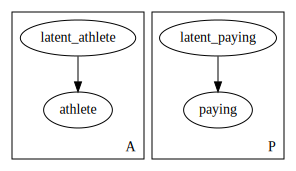

In [20]:
pyro.render_model(model)

In [21]:
pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.025})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

In [22]:
losses = []
athletic_history = []
paying_history = []
for _ in trange(25_000):
    loss = svi.step(athlete=raw_data[:,0], paying=raw_data[:, 1])
    a_alpha = pyro.param("a_alpha")
    a_beta = pyro.param("a_beta")
    p_alpha = pyro.param("p_alpha")
    p_beta = pyro.param("p_beta")
    losses.append(dict(loss=loss))
    athletic_history.append(dict(
        a_alpha=a_alpha.item(),
        a_beta=a_beta.item()))
    paying_history.append(dict(
        p_alpha=p_alpha.item(),
        p_beta=p_beta.item()))

100%|██████████| 25000/25000 [03:09<00:00, 132.06it/s]


<AxesSubplot:>

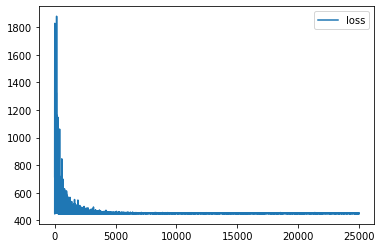

In [23]:
df = pd.DataFrame(losses)

df.plot()

<AxesSubplot:>

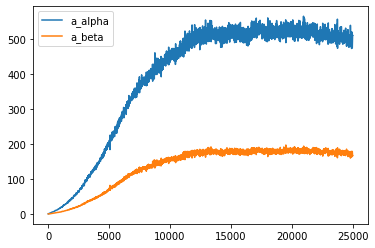

In [24]:
df = pd.DataFrame(athletic_history)

df.plot()

<AxesSubplot:>

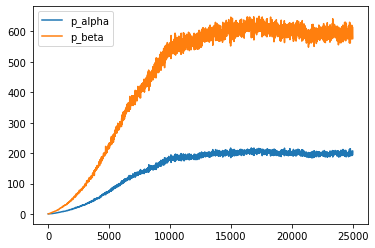

In [25]:
df = pd.DataFrame(paying_history)

df.plot()

In [26]:
dict(pyro.get_param_store())

{'a_alpha': tensor(511.7354, grad_fn=<AddBackward0>),
 'a_beta': tensor(166.9497, grad_fn=<AddBackward0>),
 'p_alpha': tensor(206.5899, grad_fn=<AddBackward0>),
 'p_beta': tensor(575.9086, grad_fn=<AddBackward0>)}

In [34]:
def model_alternative(prior_a_alpha=1., prior_a_beta=1., prior_p_alpha=1., prior_p_beta=1.):
    with pyro.plate("A"):
        latent_a = pyro.sample("latent_athlete",
                               dist.Beta(concentration0=torch.as_tensor(prior_a_alpha, dtype=torch.float), concentration1=torch.as_tensor(prior_a_beta, dtype=torch.float)))
        a = pyro.sample("athlete", dist.Bernoulli(latent_a))
    with pyro.plate("P"):
        latent_p = pyro.sample("latent_paying",
                               dist.Beta(concentration0=torch.as_tensor(prior_p_alpha, dtype=torch.float), concentration1=torch.as_tensor(prior_p_beta, dtype=torch.float)))
        p = pyro.sample("paying", dist.Bernoulli(latent_p))
    return a, p

In [45]:
cond_model_alternative = pyro.condition(model_alternative, data={"athlete": torch.tensor(1.), "paying": torch.tensor(0.), "latent_athlete": torch.tensor(100/400), "latent_paying": torch.tensor(300/400) })
cond_model = pyro.condition(model, data={"latent_athlete": torch.tensor(100/400), "latent_paying": torch.tensor(300/400)})

cond_model(athlete=1., paying=0.), cond_model_alternative()

((tensor(1.), tensor(0.)), (tensor(1.), tensor(0.)))

In [46]:
trace1 = pyro.poutine.trace(cond_model).get_trace(athlete=1., paying=0.)
trace2 = pyro.poutine.trace(cond_model_alternative).get_trace()

trace1.log_prob_sum(), trace2.log_prob_sum()

(tensor(-2.7726), tensor(-2.7726))